Energy Disaggregation using Neural Networks
=======================================

In [1]:
import sys
import numpy as np
#sys.path.append("c:/python34/lib/site-packages")
import keras
import pandas as pd
from datetime import datetime as dt
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, Conv1D, MaxPooling2D, LSTM, Bidirectional
from keras import regularizers
import keras.callbacks as cb
from matplotlib import pyplot as plt
import random
import scipy.io as sio

Using TensorFlow backend.


The following functions are used to extract the time and day information from a timestamp value.

The following function normalizes each column of the input array by substracting the mean and dividing by the standard deviation.

In [4]:
def normalize_data(X):
    for i in range(X.shape[1]):
        if np.std(X[:,i]) < 1e-4:
            den = 1e-4
        else:
            den = np.std(X[:,i])
        X[:,i] = (X[:,i]-np.mean(X[:,i]))/den
    return X

This class is used as a callback for the model fit function which is used to calculate and store the losses after each batch iteration.

In [5]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)


Model Specification
-------------------------------
The following function is used to create the model.

In [26]:
def init_model():
    model = Sequential()
    model.add(Conv1D(16, 4, activation="relu",
                    input_shape=(1200,5), padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(Dropout(0.25))
    model.add(Bidirectional(LSTM(256, return_sequences=True,
                                  stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
    model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu',kernel_initializer="he_uniform"))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='linear',kernel_initializer="he_uniform"))
    model.add(Dropout(0.25))
    model.compile(loss='mse', optimizer='adam')
    return model

The following function plots the losses against the epochs.

In [6]:
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

Data Preprocessing for ECO
------------------------------

The following function takes as input the file path, the channel index and the quantity name as input and loads the appropriate data files. It then joins themains and the output quantity based on the timestamp values, extracts time features from the timestamp and splits the input and output into two arrays.

In [14]:
from os import walk
path = "C:/Users/ghoshp/Downloads/IE594964/IE594964/REP594965/01_sm_csv/01"
f = []
for (dirpath, dirnames, filenames) in walk(path):
    f.extend(filenames)
    break
f

['2012-06-01.csv',
 '2012-06-02.csv',
 '2012-06-03.csv',
 '2012-06-04.csv',
 '2012-06-05.csv',
 '2012-06-06.csv',
 '2012-06-07.csv',
 '2012-06-08.csv',
 '2012-06-09.csv',
 '2012-06-10.csv',
 '2012-06-11.csv',
 '2012-06-12.csv',
 '2012-06-13.csv',
 '2012-06-14.csv',
 '2012-06-15.csv',
 '2012-06-16.csv',
 '2012-06-17.csv',
 '2012-06-18.csv',
 '2012-06-19.csv',
 '2012-06-20.csv',
 '2012-06-21.csv',
 '2012-06-22.csv',
 '2012-06-23.csv',
 '2012-06-24.csv',
 '2012-06-25.csv',
 '2012-06-26.csv',
 '2012-06-27.csv',
 '2012-06-28.csv',
 '2012-06-29.csv',
 '2012-06-30.csv',
 '2012-07-01.csv',
 '2012-07-02.csv',
 '2012-07-03.csv',
 '2012-07-04.csv',
 '2012-07-05.csv',
 '2012-07-06.csv',
 '2012-07-07.csv',
 '2012-07-08.csv',
 '2012-07-09.csv',
 '2012-07-10.csv',
 '2012-07-11.csv',
 '2012-07-12.csv',
 '2012-07-13.csv',
 '2012-07-14.csv',
 '2012-07-15.csv',
 '2012-07-16.csv',
 '2012-07-17.csv',
 '2012-07-18.csv',
 '2012-07-19.csv',
 '2012-07-20.csv',
 '2012-07-21.csv',
 '2012-07-22.csv',
 '2012-07-23

In [33]:
df={}
for filename in f:
    datestamp = filename[:-4].replace("-","")
    #print(datestamp)
    #if int(datestamp) >= 20120715 and int(datestamp) <= 20120825:
    df[datestamp]=pd.read_csv(path+"/"+name,header=None,names=["powerallphases","powerl1","powerl2","powerl3","currentneutral","currentl1","currentl2",
                                    "currentl3","voltagel1","voltagel2","voltagel3","phaseanglevoltagel2l1",
                                    "phaseanglevoltagel3l1","phaseanglecurrentvoltagel1","phaseanglecurrentvoltagel2",
                                    "phaseanglecurrentvoltagel3"])
len(df)

245

In [52]:
df2 = pd.read_csv("C:/Users/ghoshp/Downloads/IE594964/IE594964/REP594965/01_occupancy_csv/01_summer.csv",index_col=0)
df2.index = pd.to_datetime(df2.index)
df2.index = df2.index.strftime('%Y%m%d')
df2

,'00:00:00','00:00:01','00:00:02','00:00:03','00:00:04','00:00:05','00:00:06','00:00:07','00:00:08','00:00:09',...,'23:59:50','23:59:51','23:59:52','23:59:53','23:59:54','23:59:55','23:59:56','23:59:57','23:59:58','23:59:59'
20120715,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
20120716,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
20120717,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
20120718,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
20120720,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
20120721,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
20120722,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
20120723,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
20120724,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
20120725,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [55]:
import datetime
summer = df2.index.tolist()
# for i in range(len(summer)):
#     item = pd.to_datetime(summer[i])
#     item = item.strftime('%Y%m%d')
#     summer[i] = item
df_summer = {}
for key in df.keys():
    if key in summer:
        df_summer[key]=df[key]
len(df_summer)
#df_summer["20120730"]

39

In [62]:
n = 900  #chunk row size
for day, data in df_summer.items():
    list_df_summer = [data[i:i+n] for i in range(0,len(data),n)]
    print(np.mean(list_df_summer['powerallphases']))
#     print(list_df_summer[0])

TypeError: list indices must be integers or slices, not str

In [56]:
def create_seq(X):
    res = []
    for i in range(0,X.shape[0],900):
        res.append(X[i:i+900,:])
    res = np.array(res)
    return res
   

In [ ]:
def_calc_sad(X):
    sad = 0
    for i in range(len(X)):
        if i < len(X)-1:
            sad += X[i] + X[i+1]
    return sad

In [9]:
path1 = ("low_freq/house_1/")
X, y = loadData(path1, "6", "dishwasher")
y = y.reshape(len(y), 1)

In [91]:
res = create_seq(X[288000:345600,:])

In [92]:
res.shape

(2880, 20, 7)

In [90]:
res.shape

(57600, 7)

Training and Testing
-------------------------------

The model is trained on the"dishwasher" appliance for house 1. The training set comprises 20000 samples and the testing set comprises 2000 samples. The loss curve is plotted. he predicted values are also plotted against the actual values forthe test set.

Train on 120 samples, validate on 72 samples
Epoch 1/20
 - 903s - loss: 0.6774 - val_loss: 0.0887
Epoch 2/20
 - 732s - loss: 0.2377 - val_loss: 0.1116
Epoch 3/20
 - 648s - loss: 0.1712 - val_loss: 0.1023
Epoch 4/20
 - 515s - loss: 0.1469 - val_loss: 0.0919
Epoch 5/20
 - 662s - loss: 0.1271 - val_loss: 0.0978
Epoch 6/20
 - 862s - loss: 0.1082 - val_loss: 0.0836
Epoch 7/20
 - 601s - loss: 0.0973 - val_loss: 0.0808
Epoch 8/20
 - 687s - loss: 0.0914 - val_loss: 0.0784
Epoch 9/20
 - 563s - loss: 0.0825 - val_loss: 0.0814
Epoch 10/20
 - 544s - loss: 0.0783 - val_loss: 0.0826
Epoch 11/20
 - 481s - loss: 0.0765 - val_loss: 0.0794
Epoch 12/20
 - 783s - loss: 0.0729 - val_loss: 0.0765
Epoch 13/20
 - 866s - loss: 0.0711 - val_loss: 0.0756
Epoch 14/20
 - 839s - loss: 0.0694 - val_loss: 0.0760
Epoch 15/20
 - 660s - loss: 0.0679 - val_loss: 0.0767
Epoch 16/20
 - 594s - loss: 0.0667 - val_loss: 0.0777
Epoch 17/20
 - 523s - loss: 0.0652 - val_loss: 0.0781
Epoch 18/20
 - 498s - loss: 0.0640 - val_loss:

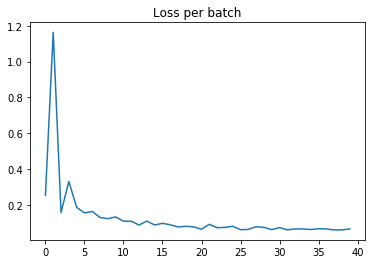

In [27]:

path1 = ("low_freq/house_1/")
X, y = loadData(path1, "6", "dishwasher")
y[y>0.5]=1
y[y<=0.5]=0
y = y.reshape(len(y), 1)
#start = random.randrange(0, X.shape[0]-27601)
#X_train = X[start:start+24000,:]
#y_train = y[start:start+24000,:]
X_train =X[0:144000,:]
y_train = y[0:144000,:]
#X_train,y_train = mini_batch(X,y,10000)
#X_test = X[start+24001:start+27601,:]
#y_test = y[start+24001:start+27601,:]
X_test = X[144000:230400,:]
y_test = y[144000:230400,:]
#X_test,y_test = mini_batch(X,y,1000)
X_train = normalize_data(X_train)
X_test = normalize_data(X_test)
#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
#X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
model = init_model()
history = LossHistory()
X_train = create_seq(X_train)
y_train = create_seq(y_train)
X_test = create_seq(X_test)
y_test = create_seq(y_test)
model.fit(X_train, y_train, epochs=20, batch_size=64,
                callbacks=[history],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=64)
print(score)
plot_losses(history.losses)

y_pred = model.predict(X_test)

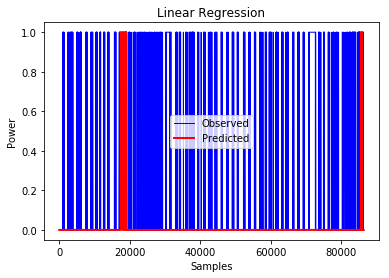

In [29]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
samples = []
data_test = []
data_pred = []
for i in range(len(y_test)):
    samples.extend(list(range(len(samples),len(samples)+len(y_test[i]))))
    data_test.extend(y_test[i])
    data_pred.extend(y_pred[i])
plt.plot(samples,data_test, color='blue', linewidth=1, label = 'Observed') 
plt.plot(samples,data_pred, color='red', linewidth=2, label = 'Predicted') 
plt.title('Linear Regression')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Power')
plt.show()

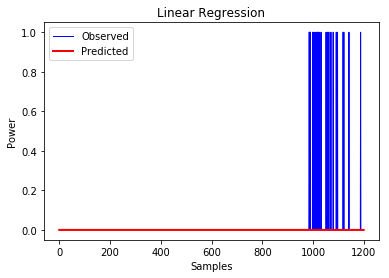

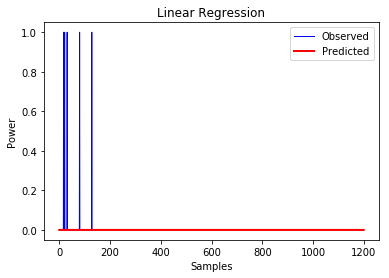

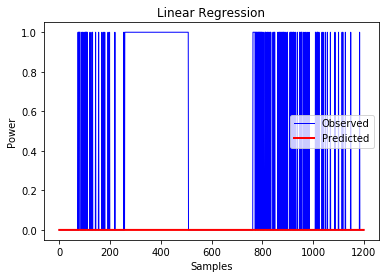

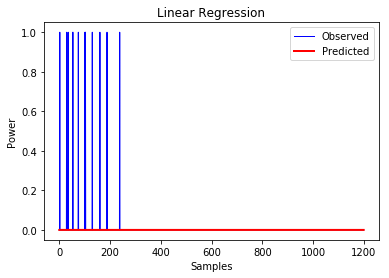

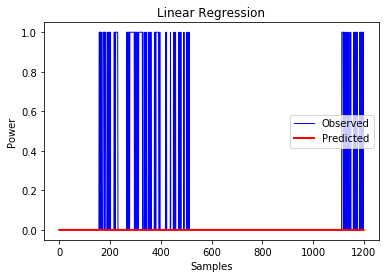

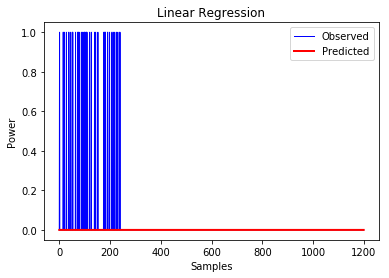

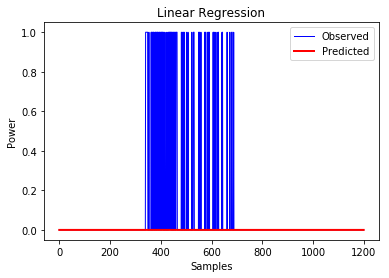

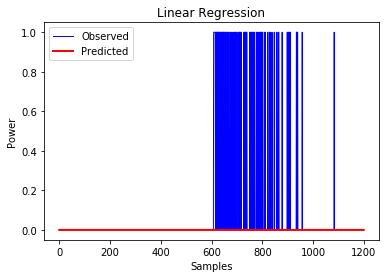

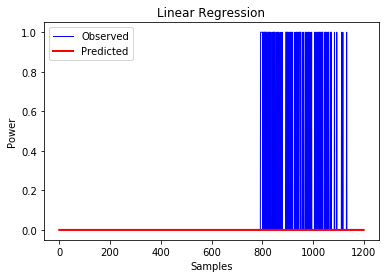

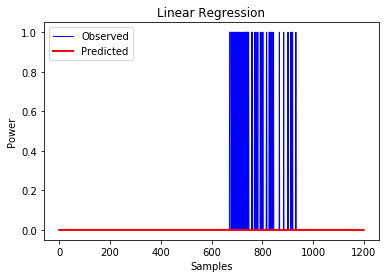

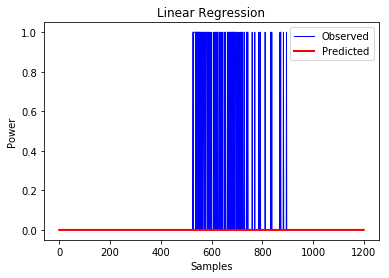

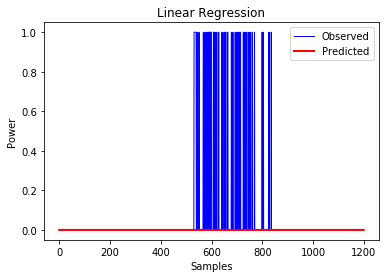

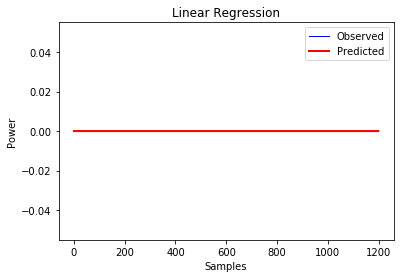

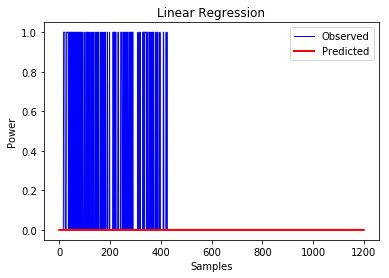

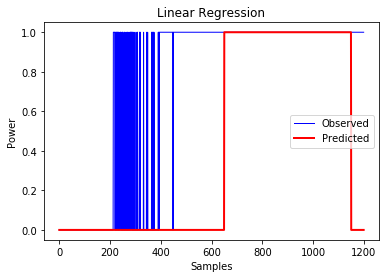

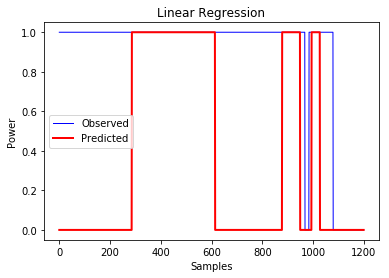

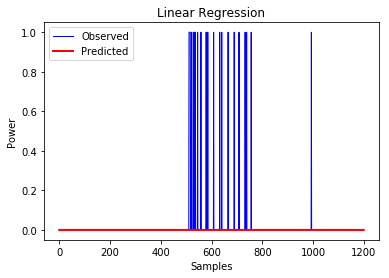

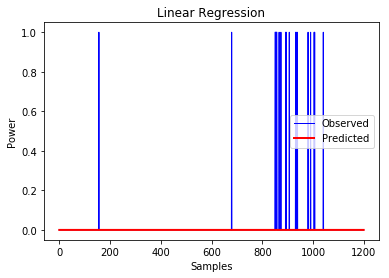

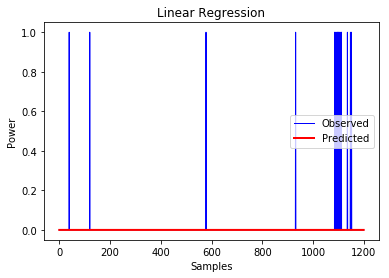

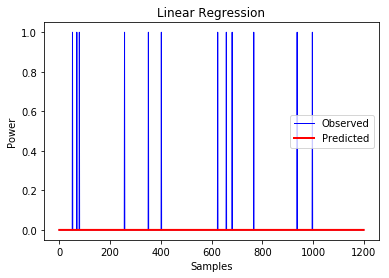

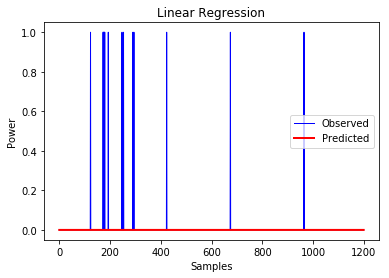

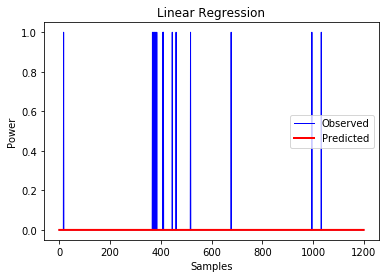

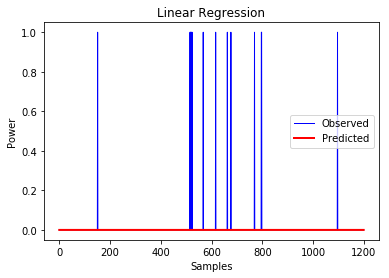

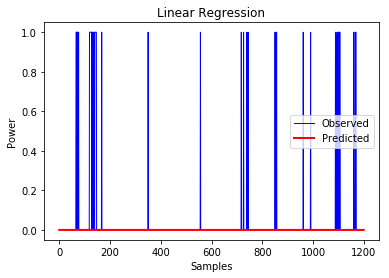

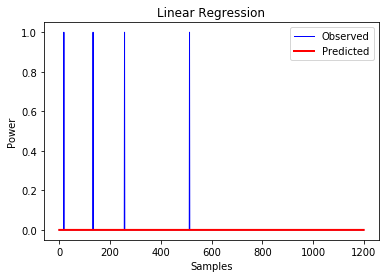

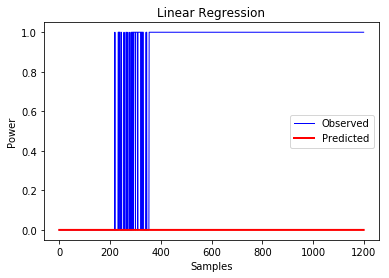

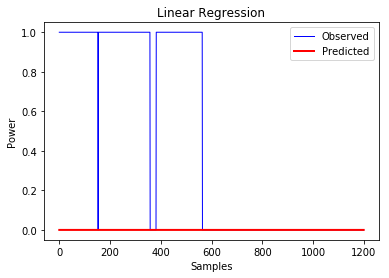

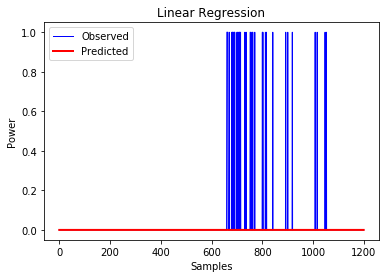

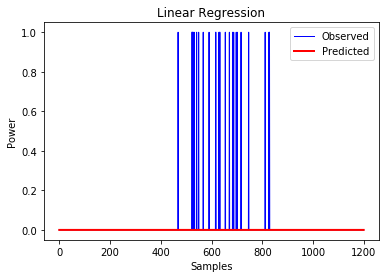

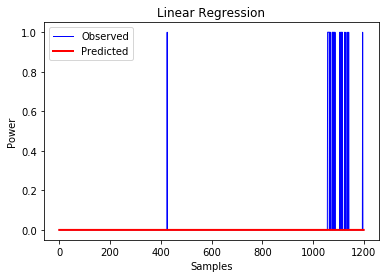

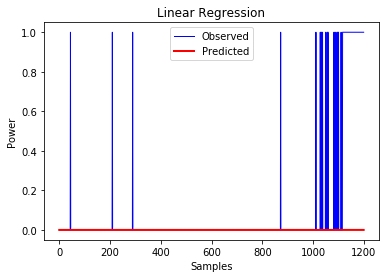

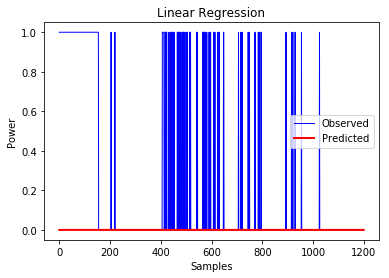

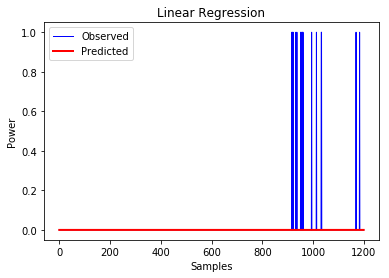

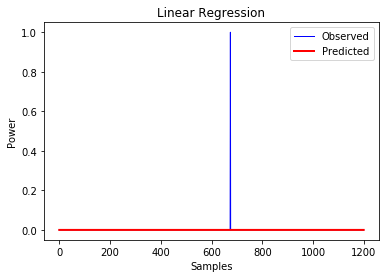

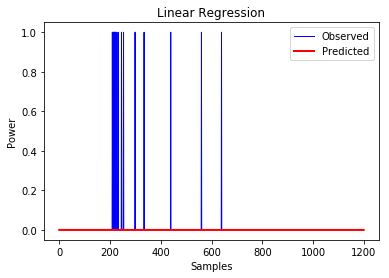

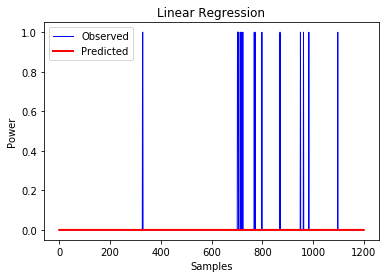

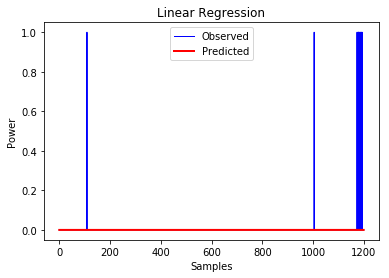

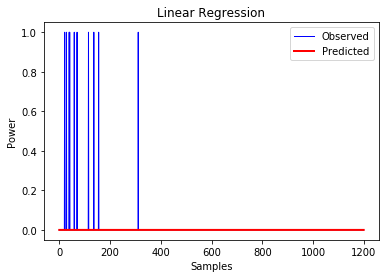

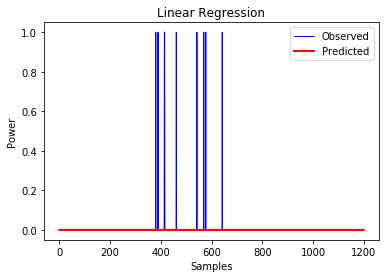

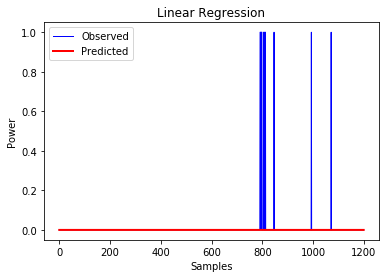

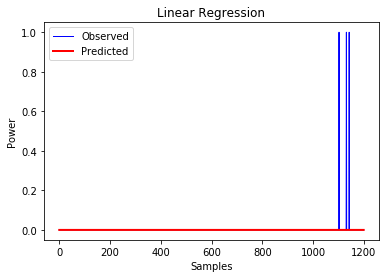

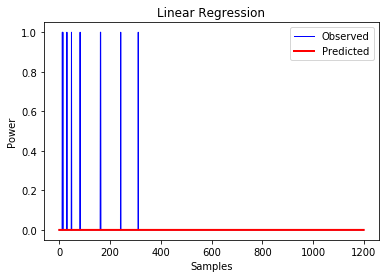

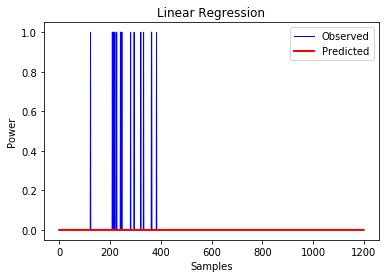

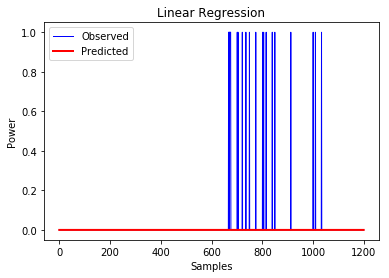

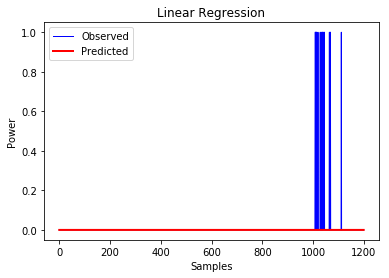

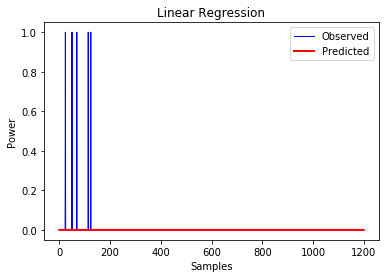

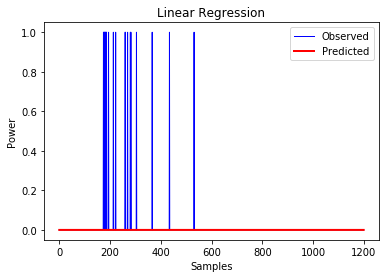

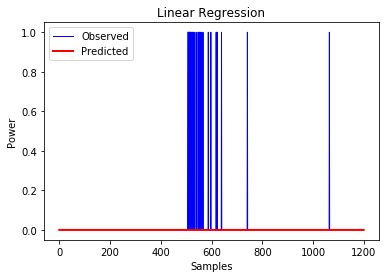

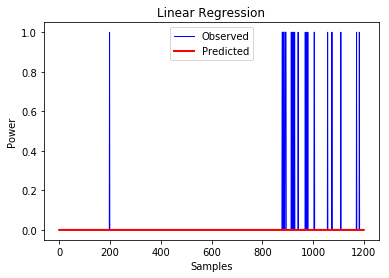

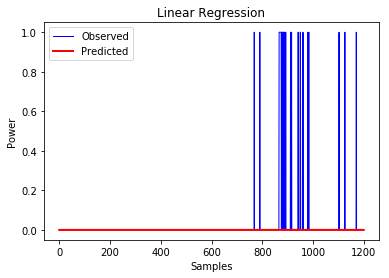

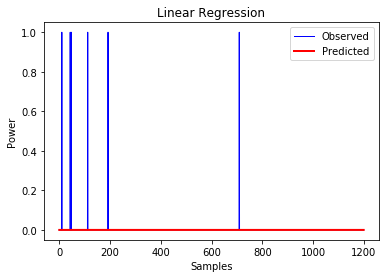

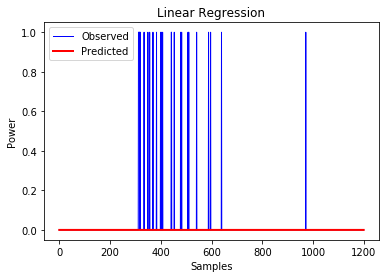

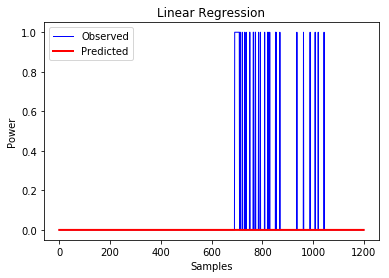

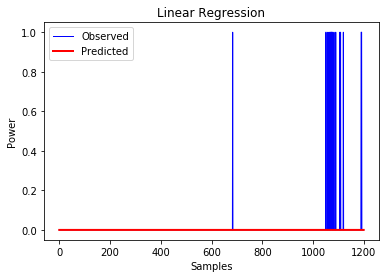

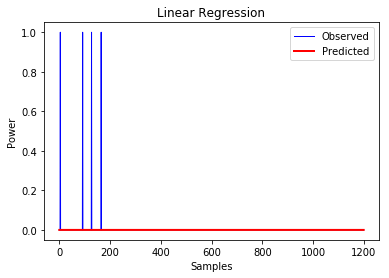

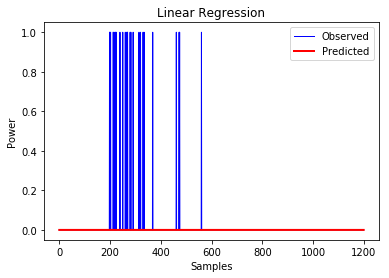

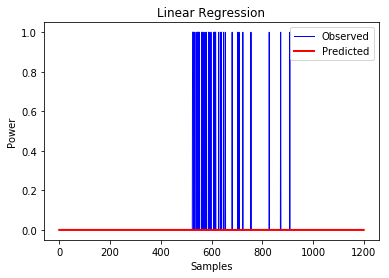

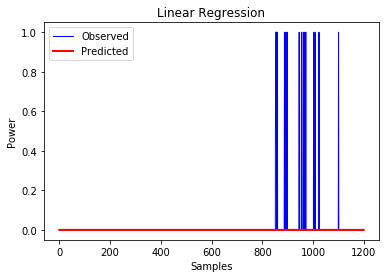

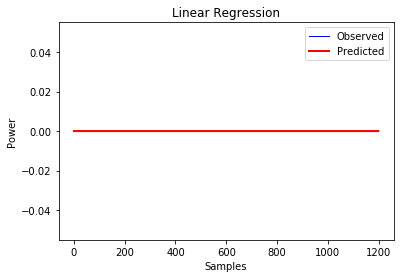

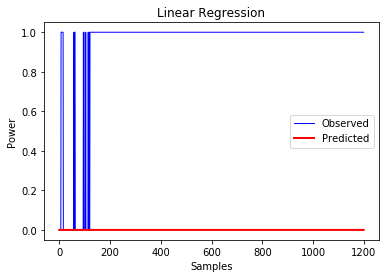

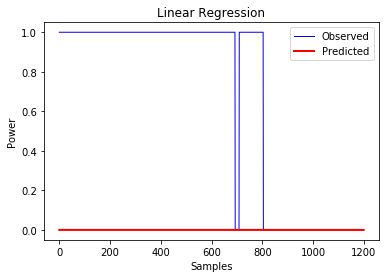

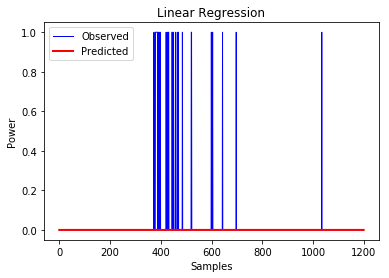

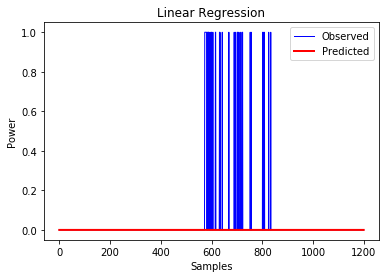

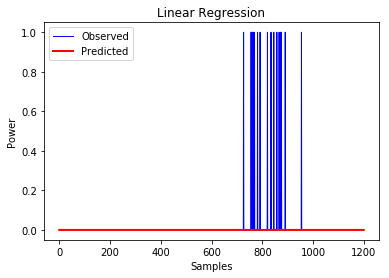

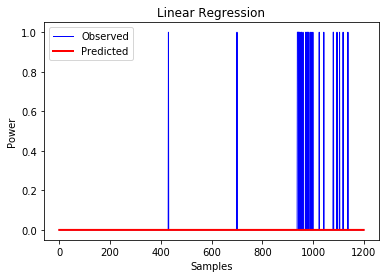

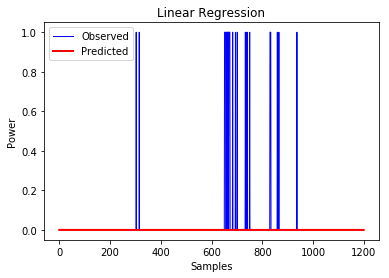

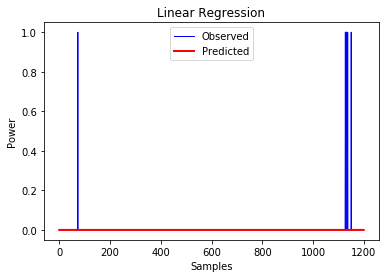

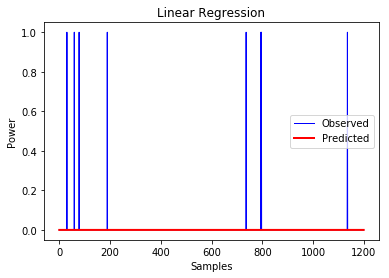

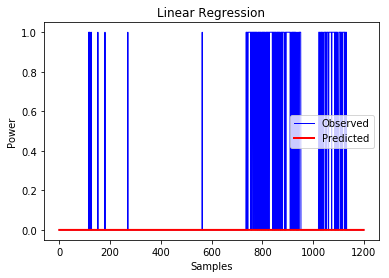

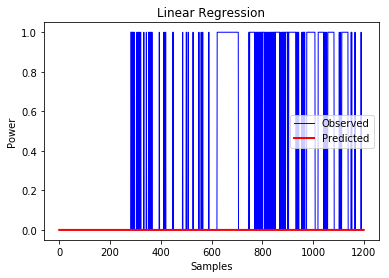

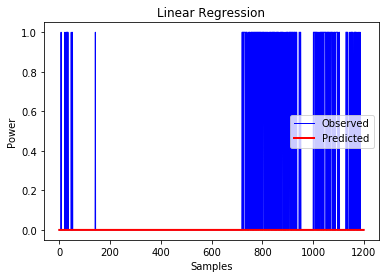

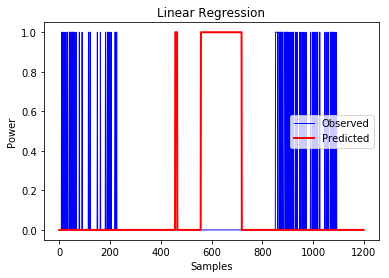

In [30]:
for i in range(len(y_test)):
    samples= list(range(len(y_test[i])))
    plt.plot(samples,y_test[i], color='blue', linewidth=1, label = 'Observed') 
    plt.plot(samples,y_pred[i], color='red', linewidth=2, label = 'Predicted') 
    plt.title('Linear Regression')
    plt.legend()
    plt.xlabel('Samples')
    plt.ylabel('Power')
    plt.show()

In [85]:
X_train.shape

(14400, 20, 7)

In [86]:
y_train.shape

(14400, 20, 1)

In [87]:
X_test.shape

(5938,)

In [15]:
len(samples)

2880

In [51]:
import scipy.io as sio
mat = sio.loadmat('Zica_2.mat')

In [64]:
mat["Zica"][0]

array([0.00413766, 0.00652668, 0.0087699 , ..., 0.54442871, 0.5457767 ,
       0.54304455])

In [65]:
X.shape
X_new = np.column_stack((X[:,0:5],mat["Zica"].T))
X_new.shape

(406748, 8)

In [49]:
collect = sio.savemat('saved_data.mat',{'X': X})

In [47]:
path1 = ("low_freq/house_1/")
X, y = loadData(path1, "6", "dishwasher")

In [48]:
{'X': X}

{'X': array([[  4.  ,   3.  ,   8.  , ...,  13.  , 222.2 , 118.83],
        [  4.  ,   3.  ,   8.  , ...,  16.  , 223.17, 119.19],
        [  4.  ,   3.  ,   8.  , ...,  20.  , 223.6 , 118.92],
        ...,
        [  5.  ,   4.  ,  14.  , ...,  27.  , 235.46,  38.61],
        [  5.  ,   4.  ,  14.  , ...,  30.  , 235.98,  38.77],
        [  5.  ,   4.  ,  14.  , ...,  34.  , 235.29,  38.83]])}

Single Channel ICA
====================

In [9]:
def init_model2():
    model = Sequential()
    model.add(Conv1D(16, 4, activation="relu",
                    input_shape=(1200,5), padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(Dropout(0.25))
    model.add(Bidirectional(LSTM(256, return_sequences=True,
                                  stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
    model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu',kernel_initializer="he_uniform"))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid',kernel_initializer="he_uniform"))
    model.add(Dropout(0.25))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

Train on 120 samples, validate on 72 samples
Epoch 1/20
 - 600s - loss: 4.2391 - val_loss: 0.0962
Epoch 2/20
 - 539s - loss: 4.0443 - val_loss: 0.0543
Epoch 3/20
 - 455s - loss: 4.0645 - val_loss: 0.0374
Epoch 4/20
 - 460s - loss: 4.0121 - val_loss: 0.0286
Epoch 5/20
 - 443s - loss: 4.0120 - val_loss: 0.0231
Epoch 6/20
 - 497s - loss: 4.0305 - val_loss: 0.0195
Epoch 7/20
 - 488s - loss: 4.0050 - val_loss: 0.0170
Epoch 8/20
 - 440s - loss: 4.0620 - val_loss: 0.0152
Epoch 9/20
 - 487s - loss: 4.0373 - val_loss: 0.0138
Epoch 10/20
 - 497s - loss: 4.0262 - val_loss: 0.0128
Epoch 11/20
 - 490s - loss: 4.0261 - val_loss: 0.0120
Epoch 12/20
 - 487s - loss: 4.0398 - val_loss: 0.0114
Epoch 13/20
 - 496s - loss: 4.0331 - val_loss: 0.0109
Epoch 14/20
 - 452s - loss: 4.0083 - val_loss: 0.0105
Epoch 15/20
 - 474s - loss: 4.0435 - val_loss: 0.0102
Epoch 16/20
 - 457s - loss: 4.0567 - val_loss: 0.0100
Epoch 17/20
 - 456s - loss: 4.0258 - val_loss: 0.0097
Epoch 18/20
 - 473s - loss: 4.0408 - val_loss:

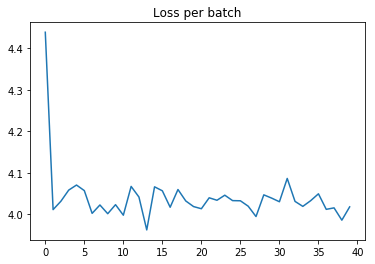

In [22]:

#path1 = ("low_freq/house_1/")
#X, y = loadData(path1, "6", "dishwasher")
#y = y.reshape(len(y), 1)
#import scipy.io as sio
mat = sio.loadmat('X_ica.mat')
#X_new = np.column_stack((X[:,0:5],mat["Zica"].T))
X_new = mat['x_ica']
y = sio.loadmat('y_bin_ica.mat')
y = y['y_bin']
X_train =X_new[0:144000,:]
y_train = y[0:144000,:]
#X_train,y_train = mini_batch(X,y,10000)
#start = random.randrange(0, X_new.shape[0]-27601)
#X_train = X_new[start:start+24000,:]
#y_train = y[start:start+24000,:]
#X_test = X_new[start+24001:start+27601,:]
#y_test = y[start+24001:start+27601,:]
X_test = X_new[144000:230400,:]
y_test = y[144000:230400,:]
#X_test,y_test = mini_batch(X,y,1000)
#X_train = normalize_data(X_train)
#X_test = normalize_data(X_test)
#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
#X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
model = init_model2()
history = LossHistory()
X_train = create_seq(X_train)
y_train = create_seq(y_train)
X_test = create_seq(X_test)
y_test = create_seq(y_test)
model.fit(X_train, y_train, epochs=20, batch_size=64,
                callbacks=[history],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=64)
print(score)
plot_losses(history.losses)

y_pred = model.predict(X_test)

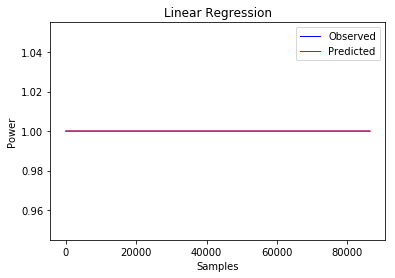

In [23]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
samples = []
data_test = []
data_pred = []
for i in range(len(y_test)):
    samples.extend(list(range(len(samples),len(samples)+len(y_test[i]))))
    data_test.extend(y_test[i])
    data_pred.extend(y_pred[i])
plt.plot(samples,data_test, color='blue', linewidth=1, label = 'Observed') 
plt.plot(samples,data_pred, color='red', linewidth=1, label = 'Predicted') 
plt.title('Linear Regression')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Power')
plt.show()

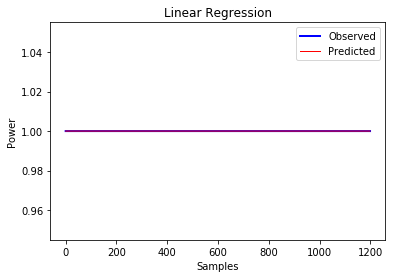

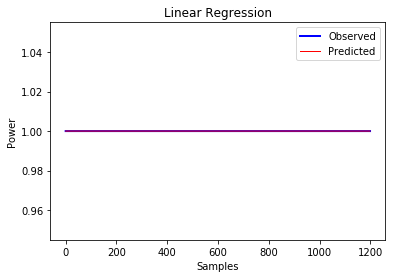

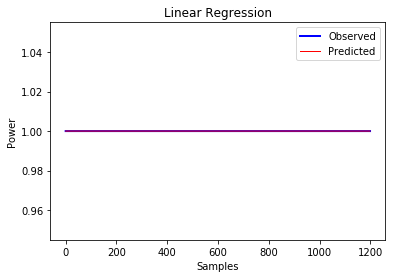

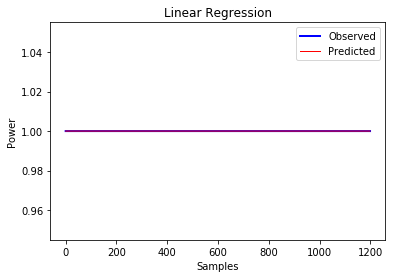

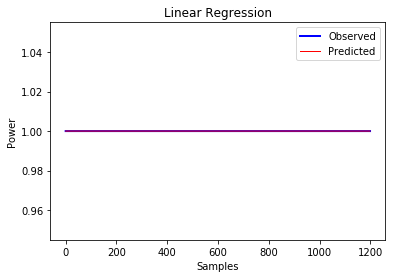

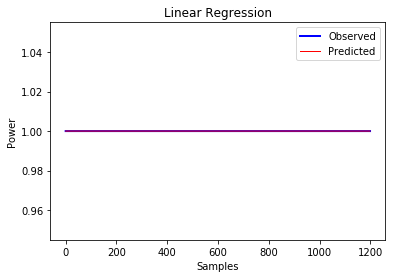

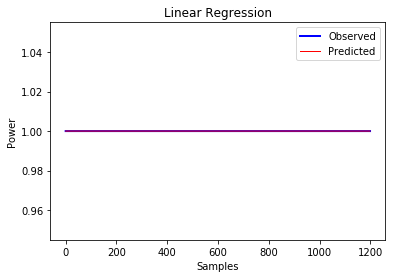

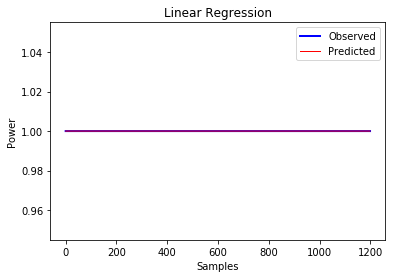

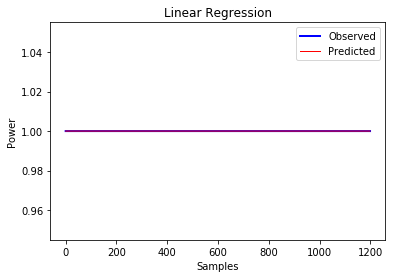

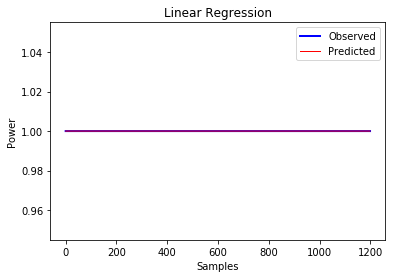

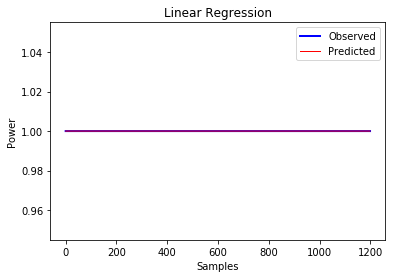

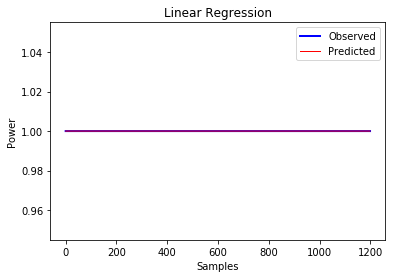

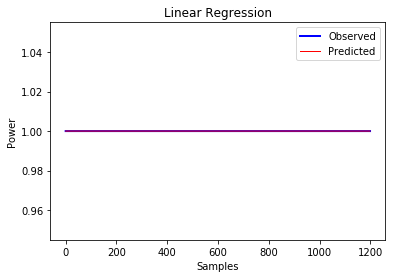

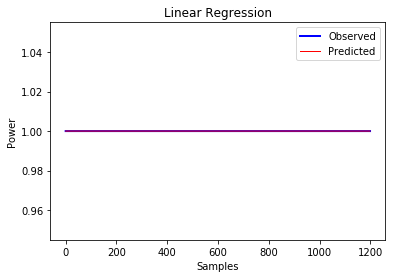

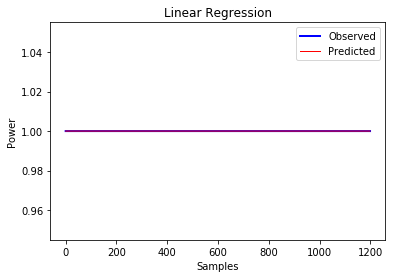

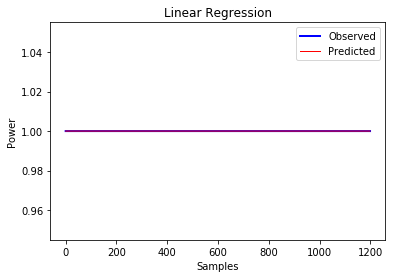

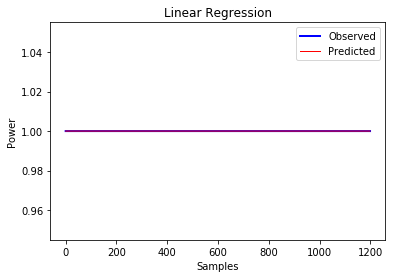

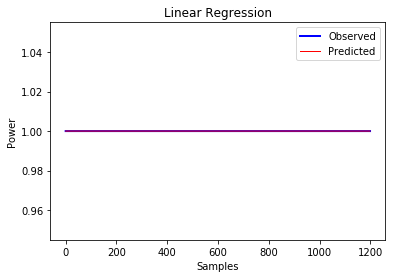

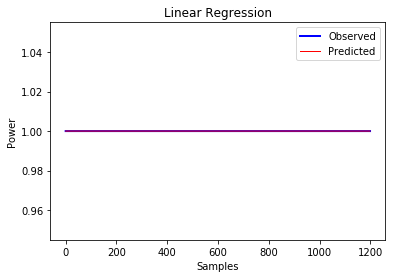

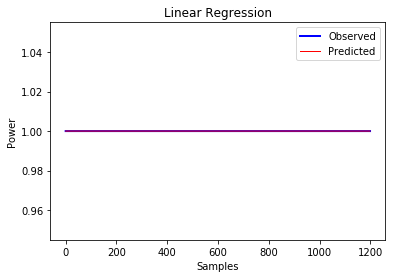

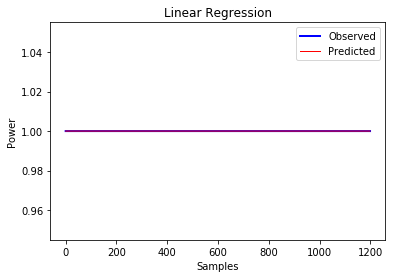

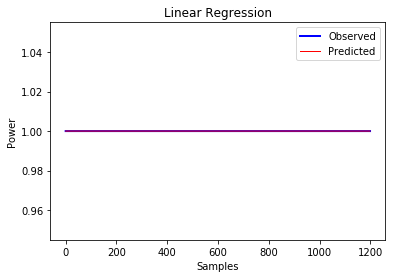

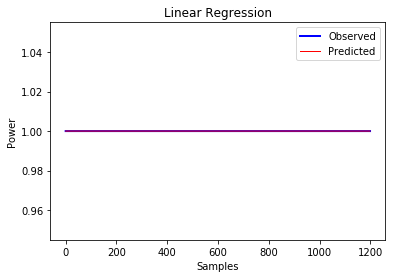

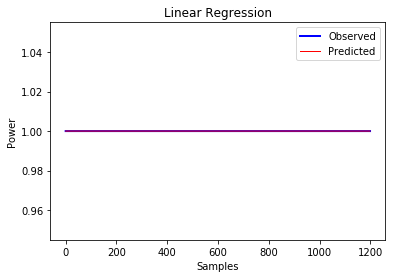

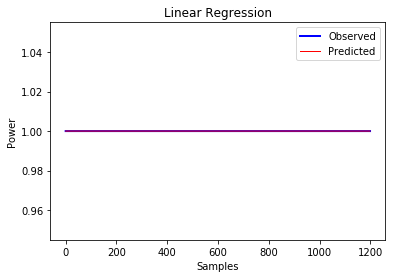

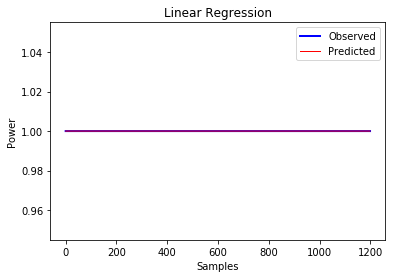

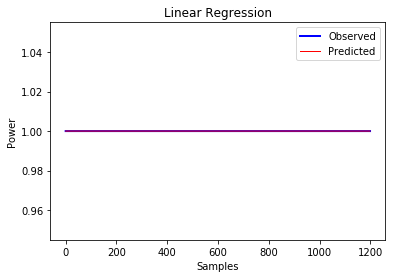

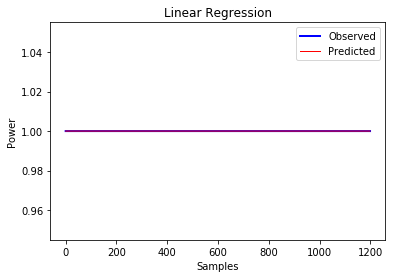

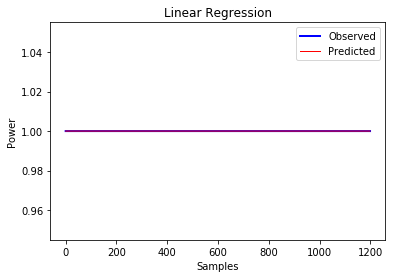

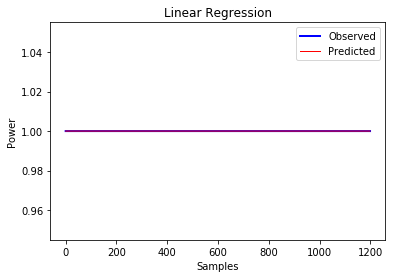

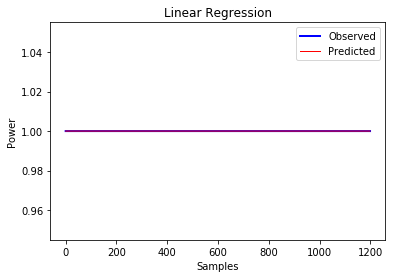

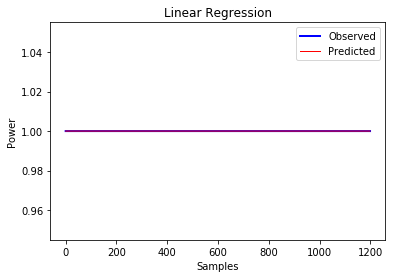

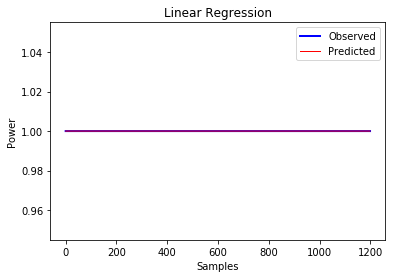

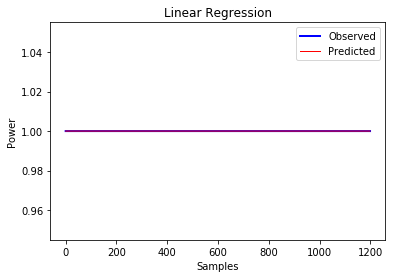

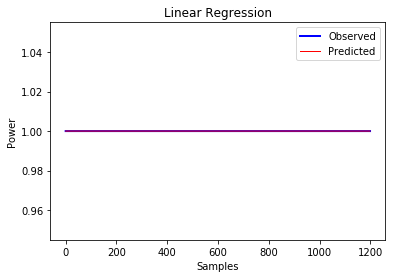

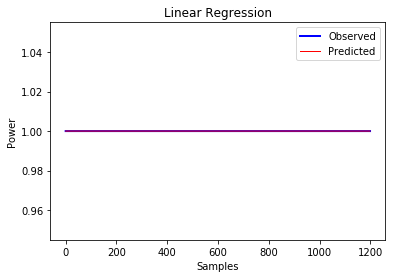

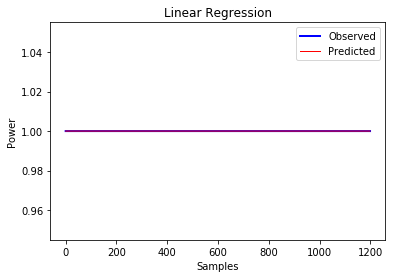

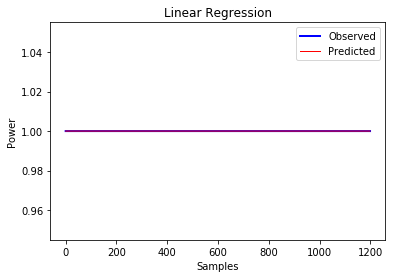

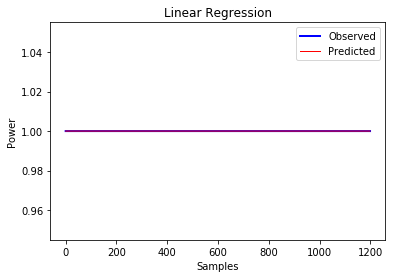

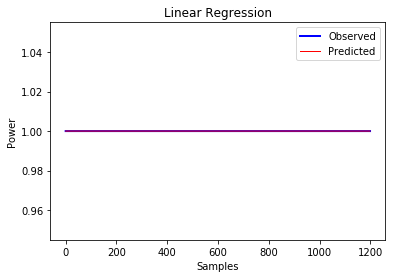

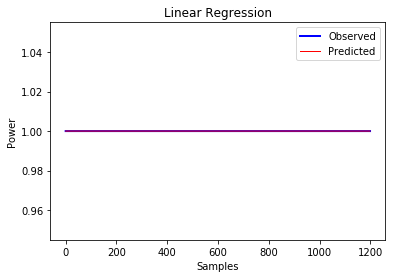

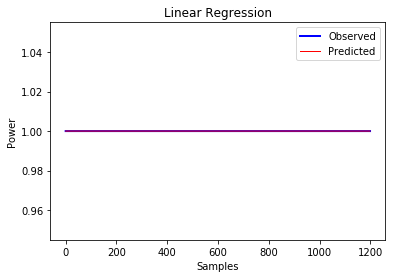

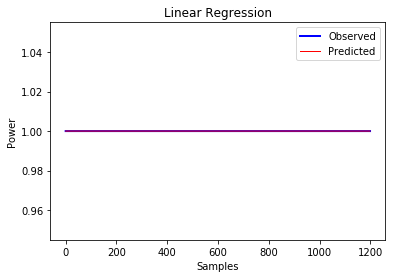

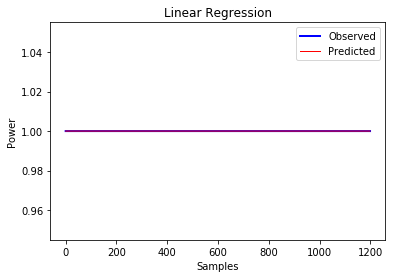

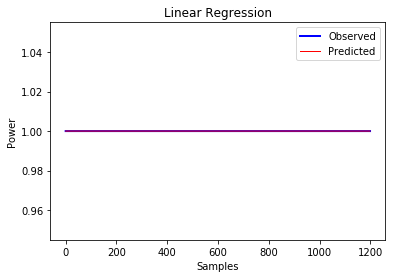

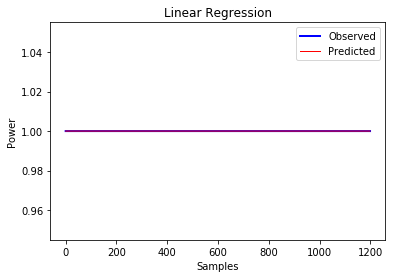

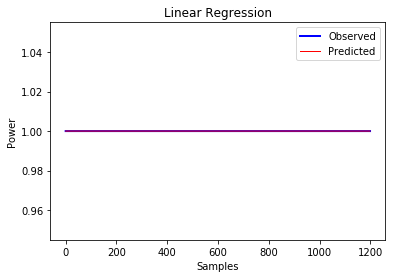

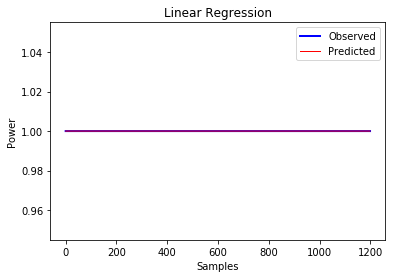

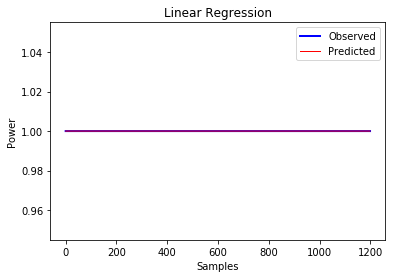

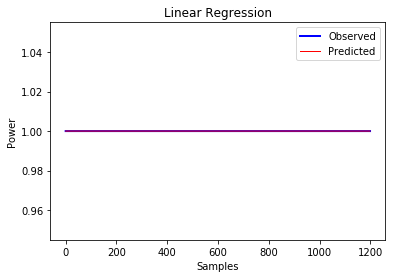

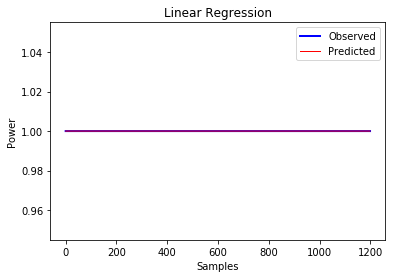

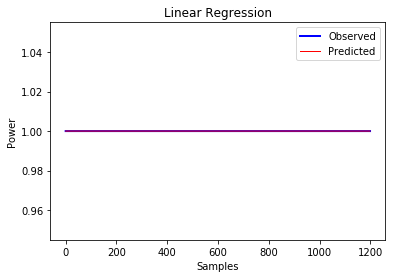

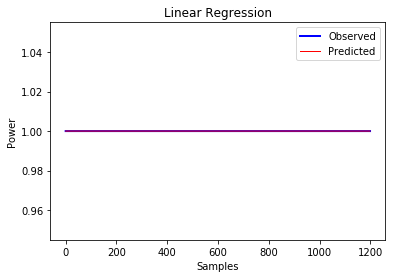

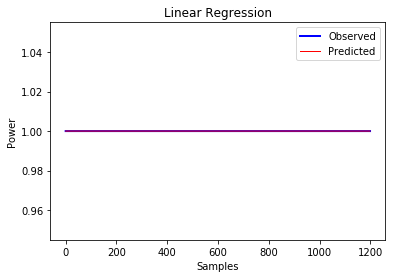

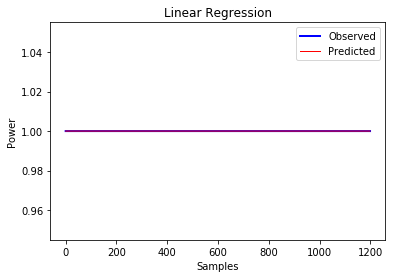

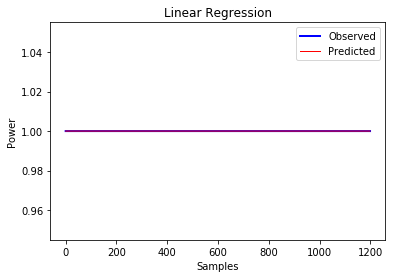

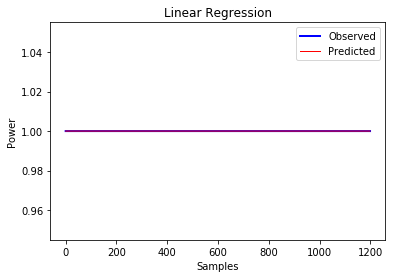

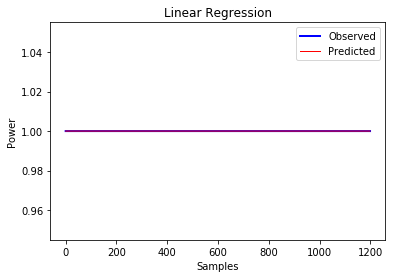

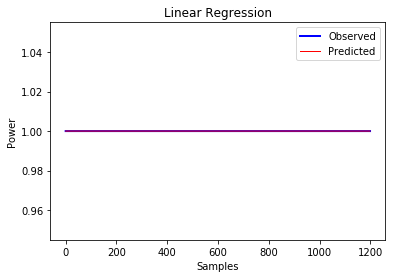

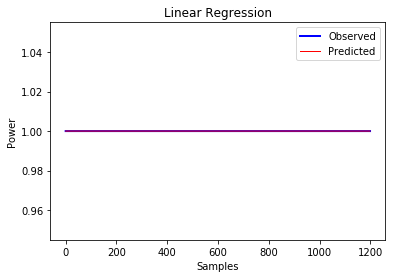

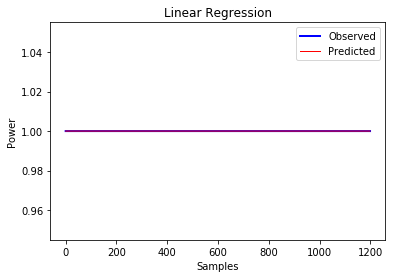

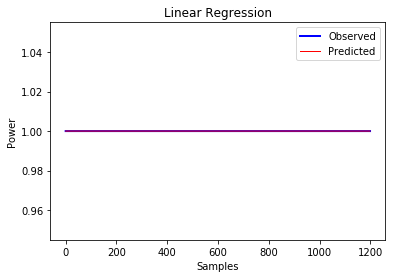

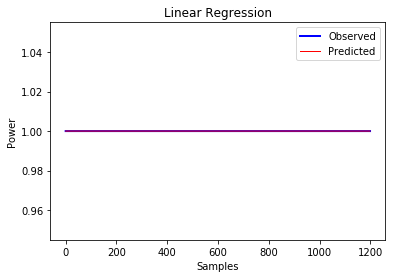

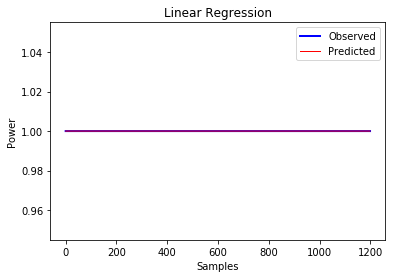

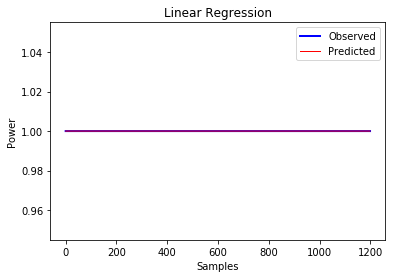

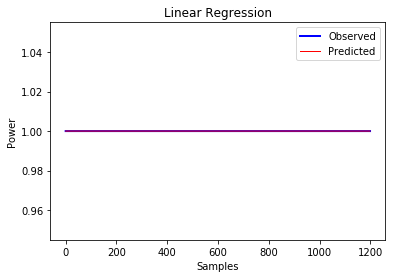

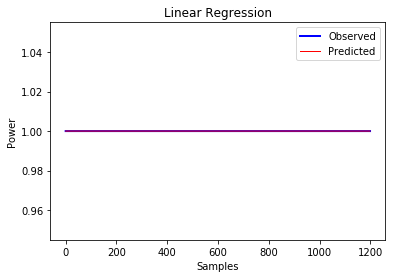

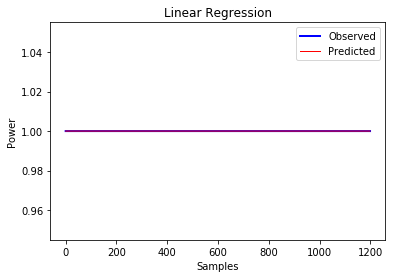

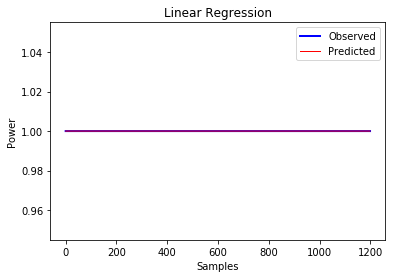

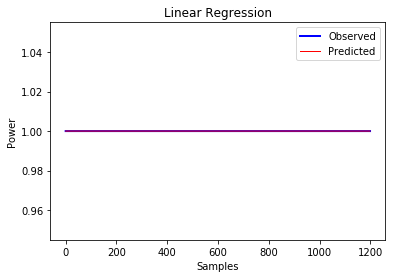

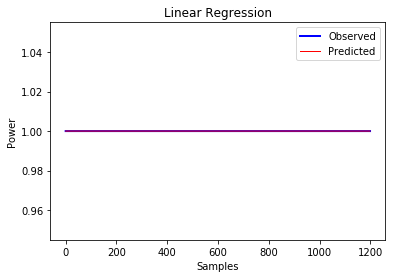

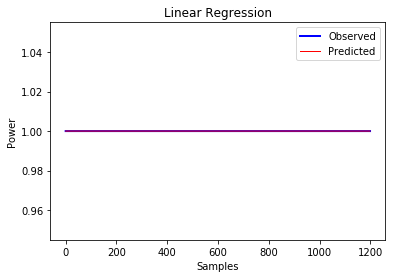

In [24]:
for i in range(len(y_test)):
    samples= list(range(len(y_test[i])))
    plt.plot(samples,y_test[i], color='blue', linewidth=2, label = 'Observed') 
    plt.plot(samples,y_pred[i], color='red', linewidth=1, label = 'Predicted') 
    plt.title('Linear Regression')
    plt.legend()
    plt.xlabel('Samples')
    plt.ylabel('Power')
    plt.show()

Train on 20 samples, validate on 3 samples
Epoch 1/50
 - 78s - loss: 0.2093 - val_loss: 0.8002
Epoch 2/50
 - 63s - loss: 1.1005 - val_loss: 0.2863
Epoch 3/50
 - 63s - loss: 0.3206 - val_loss: 0.0836
Epoch 4/50
 - 65s - loss: 0.1188 - val_loss: 0.1293
Epoch 5/50
 - 66s - loss: 0.1252 - val_loss: 0.1007
Epoch 6/50
 - 66s - loss: 0.1060 - val_loss: 0.0817
Epoch 7/50
 - 65s - loss: 0.0862 - val_loss: 0.0963
Epoch 8/50
 - 66s - loss: 0.0862 - val_loss: 0.0912
Epoch 9/50
 - 65s - loss: 0.0816 - val_loss: 0.0826
Epoch 10/50
 - 65s - loss: 0.0746 - val_loss: 0.0807
Epoch 11/50
 - 66s - loss: 0.0702 - val_loss: 0.0837
Epoch 12/50
 - 66s - loss: 0.0704 - val_loss: 0.0845
Epoch 13/50
 - 63s - loss: 0.0689 - val_loss: 0.0823
Epoch 14/50
 - 65s - loss: 0.0665 - val_loss: 0.0806
Epoch 15/50
 - 66s - loss: 0.0651 - val_loss: 0.0805
Epoch 16/50
 - 64s - loss: 0.0629 - val_loss: 0.0806
Epoch 17/50
 - 66s - loss: 0.0629 - val_loss: 0.0806
Epoch 18/50
 - 64s - loss: 0.0623 - val_loss: 0.0804
Epoch 19/50


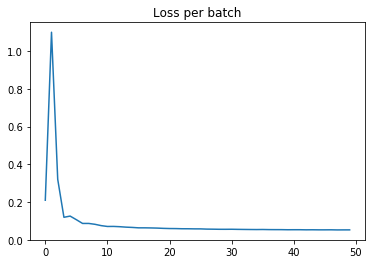

In [22]:

path1 = ("low_freq/house_1/")
X, y = loadData(path1, "6", "dishwasher")
y = y.reshape(len(y), 1)
import scipy.io as sio
mat = sio.loadmat('X_ica.mat')
#X_new = np.column_stack((X[:,0:5],mat["Zica"].T))
X_new = mat['x_ica']
#X_train =X_new[0:288000,:]
#y_train = y[0:288000,:]
#X_train,y_train = mini_batch(X,y,10000)
start = random.randrange(0, X_new.shape[0]-27601)
X_train = X_new[start:start+24000,:]
y_train = y[start:start+24000,:]
X_test = X_new[start+24001:start+27601,:]
y_test = y[start+24001:start+27601,:]
#X_test = X_new[288000:345600,:]
#y_test = y[288000:345600,:]
#X_test,y_test = mini_batch(X,y,1000)
#X_train = normalize_data(X_train)
#X_test = normalize_data(X_test)
#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
#X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
model = init_model2()
history = LossHistory()
X_train = create_seq(X_train)
y_train = create_seq(y_train)
X_test = create_seq(X_test)
y_test = create_seq(y_test)
model.fit(X_train, y_train, epochs=50, batch_size=64,
                callbacks=[history],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=64)
print(score)
plot_losses(history.losses)

y_pred = model.predict(X_test)

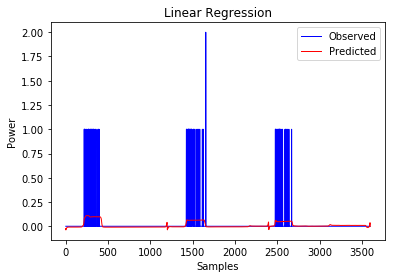

In [20]:
samples = []
data_test = []
data_pred = []
for i in range(len(y_test)):
    samples.extend(list(range(len(samples),len(samples)+len(y_test[i]))))
    data_test.extend(y_test[i])
    data_pred.extend(y_pred[i])
plt.plot(samples,data_test, color='blue', linewidth=1, label = 'Observed') 
plt.plot(samples,data_pred, color='red', linewidth=1, label = 'Predicted') 
plt.title('Linear Regression')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Power')
plt.show()

Wavelet
=======

In [33]:
def init_model3():
    model = Sequential()
    model.add(Conv1D(16, 4, activation="relu",
                    input_shape=(1200,9), padding="same", strides=1))
    model.add(Dropout(0.25))
    model.add(Bidirectional(LSTM(256, return_sequences=True,
                                  stateful=False), merge_mode='concat'))
    model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='linear'))
    model.add(Dropout(0.25))
    model.compile(loss='mse', optimizer='adam')
    return model

Train on 20 samples, validate on 3 samples
Epoch 1/20
 - 107s - loss: 0.0783 - val_loss: 0.0907
Epoch 2/20
 - 80s - loss: 0.1217 - val_loss: 0.0583
Epoch 3/20
 - 79s - loss: 0.0936 - val_loss: 0.0463
Epoch 4/20
 - 80s - loss: 0.0775 - val_loss: 0.0498
Epoch 5/20
 - 79s - loss: 0.0791 - val_loss: 0.0474
Epoch 6/20
 - 81s - loss: 0.0746 - val_loss: 0.0479
Epoch 7/20
 - 81s - loss: 0.0724 - val_loss: 0.0510
Epoch 8/20
 - 81s - loss: 0.0721 - val_loss: 0.0553
Epoch 9/20
 - 82s - loss: 0.0705 - val_loss: 0.0613
Epoch 10/20
 - 84s - loss: 0.0701 - val_loss: 0.0625
Epoch 11/20
 - 82s - loss: 0.0678 - val_loss: 0.0617
Epoch 12/20
 - 82s - loss: 0.0667 - val_loss: 0.0631
Epoch 13/20
 - 83s - loss: 0.0654 - val_loss: 0.0727
Epoch 14/20
 - 84s - loss: 0.0635 - val_loss: 0.0960
Epoch 15/20
 - 83s - loss: 0.0622 - val_loss: 0.1361
Epoch 16/20
 - 83s - loss: 0.0610 - val_loss: 0.1797
Epoch 17/20
 - 84s - loss: 0.0571 - val_loss: 0.2342
Epoch 18/20
 - 83s - loss: 0.0553 - val_loss: 0.3179
Epoch 19/20

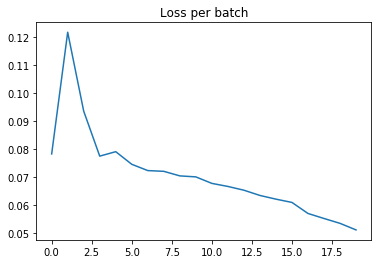

In [38]:
mat = sio.loadmat('X_new.mat')
X_new = mat['x_new']
X_train =X_new[0:288000,:]
y_train = y[0:288000,:]
#X_train,y_train = mini_batch(X,y,10000)
start = random.randrange(0, X_new.shape[0]-27601)
X_train = X_new[start:start+24000,:]
y_train = y[start:start+24000,:]
X_test = X_new[start+24001:start+27601,:]
y_test = y[start+24001:start+27601,:]
#X_test = X_new[288000:345600,:]
#y_test = y[288000:345600,:]
#X_test,y_test = mini_batch(X,y,1000)
X_train = normalize_data(X_train)
X_test = normalize_data(X_test)
#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
#X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
model = init_model3()
history = LossHistory()
X_train = create_seq(X_train)
y_train = create_seq(y_train)
X_test = create_seq(X_test)
y_test = create_seq(y_test)
model.fit(X_train, y_train, epochs=20, batch_size=64,
                callbacks=[history],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=64)
print(score)
plot_losses(history.losses)

y_pred = model.predict(X_test)

In [22]:
mat = sio.loadmat('X_new.mat')

In [27]:
mat['x_new'].shape

(406748, 7)

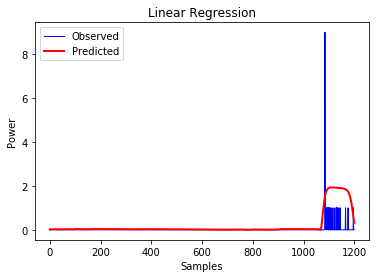

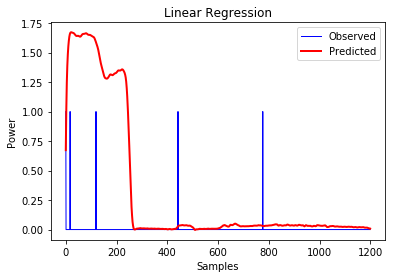

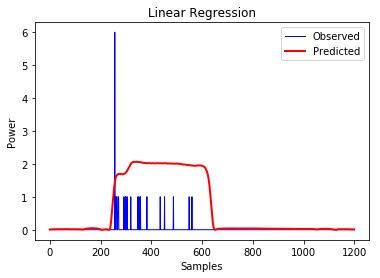

In [39]:
for i in range(len(y_test)):
    samples= list(range(len(y_test[i])))
    plt.plot(samples,y_test[i], color='blue', linewidth=1, label = 'Observed') 
    plt.plot(samples,y_pred[i], color='red', linewidth=2, label = 'Predicted') 
    plt.title('Linear Regression')
    plt.legend()
    plt.xlabel('Samples')
    plt.ylabel('Power')
    plt.show()